## Convert `HDDM` model object to `ArviZ`

Author: Hu Chuan-Peng (PhD)

Contact: hcp4715 AT hotmail.com

We will use the example from [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html), and tried to convert the `HDDM` object to `Arviz` `InferenceData`.

So far, I haven't finished the `prior` part and the `log likelihood` part.

Note: to conver the posterior predictive needs substantial amount of memory, make sure that your machine's RAM is large enough.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print("The current HDDM version is: ", hddm.__version__)

The current HDDM version is:  0.8.0


/opt/conda/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.7/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


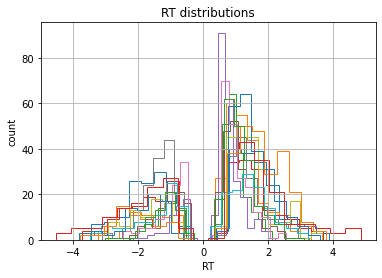

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

## Fitting a hierarchical model with four chains

#### Depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(2000, burn=500)
```

**Make sure that Ipython Cluster has started multiple engines**

In [7]:
# define a function to check the progress bar of the sampling
import sys
import time
from IPython.display import clear_output

def wait_watching_stdout(ar, dt=15):
    """
    ar: vmap output of the models being run 
    dt: number of seconds between checking output, you can make is shorter or longer.
    """

    while not ar.ready():
        stdouts = ar.stdout
        if not any(stdouts):
            continue
        # clear_output doesn't do much in terminal environments
        clear_output()
        print('-' * 30)
        print("%.3fs elapsed" % ar.elapsed)
        print("")
        for out in ar.stdout: print(out);
        sys.stdout.flush()
        time.sleep(dt)

In [8]:
# define a function to run model in parallel
def run_m(id):
    print('running model (depends on stim) %i'%id);
    
    import hddm
    
    exp_name = 'cavanagh'
    model_tag = 'm'
    
    #### USE absolute pathes in docker.
    # define the database name, which uses pickle format
    dbname = '/home/jovyan/example/df_' + exp_name + '_' + model_tag + '_chain_%i.db'%id 
    # define the name for the model
    mname  = '/home/jovyan/example/df_' + exp_name + '_' + model_tag + '_chain_%i'%id    
    fname  = '/opt/conda/lib/python3.7/site-packages/hddm/examples/cavanagh_theta_nn.csv'
    data = hddm.load_csv(fname)
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(2000, burn=500,dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [21]:
from ipyparallel import Client

v = Client()[:]

start_time = time.time()  # the start time of the processing

jobs = v.map(run_m, range(4)) # 4 is the number of CPUs

wait_watching_stdout(jobs)

m_stim_list = jobs.get()

print("\nRunning 4 chains used: %f seconds." % (time.time() - start_time))

------------------------------
270.588s elapsed

running model (depends on stim) 0
 [-----------------98%----------------- ] 1962 of 2000 complete in 266.0 sec
running model (depends on stim) 1
 [-----------------97%----------------- ] 1948 of 2000 complete in 265.8 sec
running model (depends on stim) 2
 [-----------------96%----------------  ] 1938 of 2000 complete in 265.8 sec
running model (depends on stim) 3
 [-----------------96%----------------  ] 1935 of 2000 complete in 266.3 sec



Running 4 chains used: 285.603693 seconds.


In [10]:
# Uncomment the code below if you already stored the model objects:
m_stim_list = []
exp_name = 'cavanagh'
model_tag = 'm'
for i in range(4):
    mname  = '/home/jovyan/example/df_' + exp_name + '_' + model_tag + '_chain_%i'%i 
    print(mname)
    m = hddm.load(mname)
    m_stim_list.append(m)

/home/jovyan/example/df_cavanagh_m_chain_0
/home/jovyan/example/df_cavanagh_m_chain_1
/home/jovyan/example/df_cavanagh_m_chain_2
/home/jovyan/example/df_cavanagh_m_chain_3


#### prepare the posterior predictive

Need to be parallalized in the future.

* Note 1: the number of sample is consistent with posterior
* Note 2: this part eats a lot of memory, keep the number of sample small at beginning.

In [11]:
df_stim_post_preds = []
for i in range(4):
    m = m_stim_list[i]
    df_post_pred = hddm.utils.post_pred_gen(m, samples = 1000) # number of samples can be reduced (?)
    df_post_pred.reset_index(inplace=True)
    df_post_pred['chain'] = i
    df_post_pred.rename(columns={'sample':'draw',
                                 'level_2':'trial'}, inplace=True)
    print('\nchain', i, df_post_pred.shape)
    df_stim_post_preds.append(df_post_pred)

# delete interim variables to save memory
del m
del df_post_pred

 [------------------107%------------------] 45 of 42 complete in 486.4 sec
chain 0 (3988000, 6)
 [------------------107%------------------] 45 of 42 complete in 489.2 sec
chain 1 (3988000, 6)
 [------------------107%------------------] 45 of 42 complete in 489.0 sec
chain 2 (3988000, 6)
 [------------------107%------------------] 45 of 42 complete in 489.1 sec
chain 3 (3988000, 6)


## Convert HDDM objects to ArviZ

Let's try to compare `m_stim_list` and `m_reg_list` in the above models.

To convert a `HDDM` object to an `ArviZ` InferenceData and use all the functionality of `ArviZ`, we need to convert the following parts (see more details about Ariviz InferenceData [here](https://arviz-devs.github.io/arviz/schema/schema.html#posterior-predictive)):

* observed_data: the data on which the posterior is conditional. Each variable should have a counter part.

* Posterior: Samples from the posterior distribution $p(\theta | y)$, which is the trace from pymc.

* posterior_predictive: the posterior predictive distribution evaluated at the `observed_data`. Samples should match with `posterior` ones and its variables should match `observed_data` variables. The `observed_data` counterpart variable may have a different name.

* **sample_stats**: Information and diagnostics for each `posterior` sample, provided by the inference backend.

* **log_likelihood**: pointwise log likelihood data. Sample shoudl match with `posteior` ones and its variables should match `observed_data` variables.

* **prior**: Samples from the prior distriubtion $p(\theta)$. Samples need not to match `posterior`. still follow the convertion on `chain` and `draw` as first dimensions.

* **prior_predictive**: Samples from the `prior` predictive distribution. Samples should match `prior` samples and each variable should have a counterpart in `posterior_predictive/observed_data`.


So far, I converted the observed data, posterior, and posterior predictive. We can use the plot function from ArviZ.

For model evaluation functions of `ArviZ`, which need `log likelihood`, has been converted yet. That said, `az.loo()` and `az.waic()` is not supported yet.

In [12]:
import arviz as az
import numpy as np
import pandas as pd
import xarray as xr

In [13]:
print("DIC of m_depends_on is %.5f" % m_stim_list[0].dic)

DIC of m_depends_on is 10788.26237


### `observed_data`

In this example data, we have 14 participants, each with three different conditions, each condition has different trial numbers.

In [14]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

Here I created an temporary data to store the observed data and then converted it to `xarrage` data.

In [15]:
data_tmp = data.copy()
data_tmp['trial'] = data_tmp.groupby(['subj_idx', 'stim']).cumcount()
data_tmp.drop(['theta','dbs','conf'], axis=1, inplace=True)
data_tmp.head()

,subj_idx,stim,rt,response,trial
0,0,LL,1.21,1.0,0
1,0,WL,1.63,1.0,0
2,0,WW,1.03,1.0,0
3,0,WL,2.77,1.0,1
4,0,WW,-1.14,0.0,1


In [16]:
data_tmp = data_tmp.set_index(["subj_idx", "stim", 'trial'])
xdata_observed = xr.Dataset.from_dataframe(data_tmp)
xdata_observed

<xarray.Dataset>
Dimensions:   (stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * subj_idx  (subj_idx) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (subj_idx, stim, trial) float64 1.21 2.0 1.72 1.72 ... nan nan nan
    response  (subj_idx, stim, trial) float64 1.0 1.0 1.0 1.0 ... nan nan nan

### `posterior`
The `posterior` are from the traces

In [17]:
df_stim_traces = []
for i in range(4):
    m = m_stim_list[i]
    df_trace = m.get_traces()
    df_trace['chain'] = i
    df_trace['draw'] = np.arange(len(df_trace), dtype=int)
    print('chain', i, df_trace.shape)
    df_stim_traces.append(df_trace)
df_stim_traces = pd.concat(df_stim_traces)
df_stim_traces = df_stim_traces.set_index(["chain", "draw"])

chain 0 (4000, 80)
chain 1 (4000, 80)
chain 2 (4000, 80)
chain 3 (4000, 80)


In [18]:
xposterior_stim = xr.Dataset.from_dataframe(df_stim_traces)
xposterior_stim

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 4000)
Coordinates:
  * chain          (chain) int64 0 1 2 3
  * draw           (draw) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999
Data variables: (12/78)
    a              (chain, draw) float64 1.922 1.994 1.912 ... 1.951 2.043 1.833
    a_std          (chain, draw) float64 0.3092 0.3455 0.344 ... 0.3967 0.4032
    a_subj.0       (chain, draw) float64 2.196 2.172 2.105 ... 2.081 2.248 2.264
    a_subj.1       (chain, draw) float64 2.158 2.129 2.114 ... 2.301 2.274 2.277
    a_subj.2       (chain, draw) float64 1.551 1.534 1.555 ... 1.562 1.591 1.591
    a_subj.3       (chain, draw) float64 2.166 2.105 2.155 ... 2.279 2.23 2.118
    ...             ...
    t_subj.8       (chain, draw) float64 0.5943 0.4843 0.5818 ... 0.5484 0.5266
    t_subj.9       (chain, draw) float64 0.37 0.3465 0.3721 ... 0.3807 0.3906
    t_subj.10      (chain, draw) float64 0.6575 0.6381 0.6452 ... 0.6589 0.6585
    t_subj.11      (chain, draw) float64 0.5807 0.5867 0.605 ... 0.5948 0.6198
    t_subj.12      (chain, draw) float64 0.3949 0.4193 0.3779 ... 0.3956 0.3843
    t_subj.13      (chain, draw) float64 0.5409 0.5222 0.5057 ... 0.5148 0.5079

### `posterior_predictive`


In [19]:
df_stim_ppc = []
for i in range(4):
    df_post_pred = df_stim_post_preds[i]
    df_post_pred['chain'] = i
    # df_post_pred['draw'] = np.arange(len(df), dtype=int)
    # print('chain', i, df.shape)
    df_post_pred[['stim', 'subj_idx']] = df_post_pred['node'].str.split(pat='\.', expand=True)

    # extract the stim string between "(" and ")"

    df_post_pred['stim'] = df_post_pred['stim'].str.extract('.*\((.*)\).*')
    df_post_pred.drop('node', axis=1, inplace=True)
    df_stim_ppc.append(df_post_pred)

# df_stim_ppc = df_stim_traces.set_index(["chain", "draw"])

In [20]:
del df_post_pred

In [21]:
df_stim_ppc = pd.concat(df_stim_ppc)
df_stim_ppc.head()

,draw,trial,rt,response,chain,stim,subj_idx
0,0,0,1.59909,1.0,0,LL,0
1,0,1,1.75699,1.0,0,LL,0
2,0,2,0.98099,1.0,0,LL,0
3,0,3,-0.80579,0.0,0,LL,0
4,0,4,1.09699,1.0,0,LL,0


In [22]:
df_stim_ppc = df_stim_ppc.set_index(["chain", "draw",'subj_idx', 'stim', 'trial'])
xdata_post_pred = xr.Dataset.from_dataframe(df_stim_ppc) # also eat memory here
xdata_post_pred

<xarray.Dataset>
Dimensions:   (chain: 4, draw: 1000, stim: 3, subj_idx: 14, trial: 157)
Coordinates:
  * chain     (chain) int64 0 1 2 3
  * draw      (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * subj_idx  (subj_idx) object '0' '1' '10' '11' '12' ... '5' '6' '7' '8' '9'
  * stim      (stim) object 'LL' 'WL' 'WW'
  * trial     (trial) int64 0 1 2 3 4 5 6 7 ... 149 150 151 152 153 154 155 156
Data variables:
    rt        (chain, draw, subj_idx, stim, trial) float64 1.599 1.757 ... nan
    response  (chain, draw, subj_idx, stim, trial) float64 1.0 1.0 ... nan nan

In [23]:
InfData_stim = az.InferenceData(posterior=xposterior_stim, observed_data=xdata_observed,
                                posterior_predictive=xdata_post_pred)

InfData_stim

Inference data with groups:
	> posterior
	> posterior_predictive
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fab6ce981d0>,
      dtype=object)

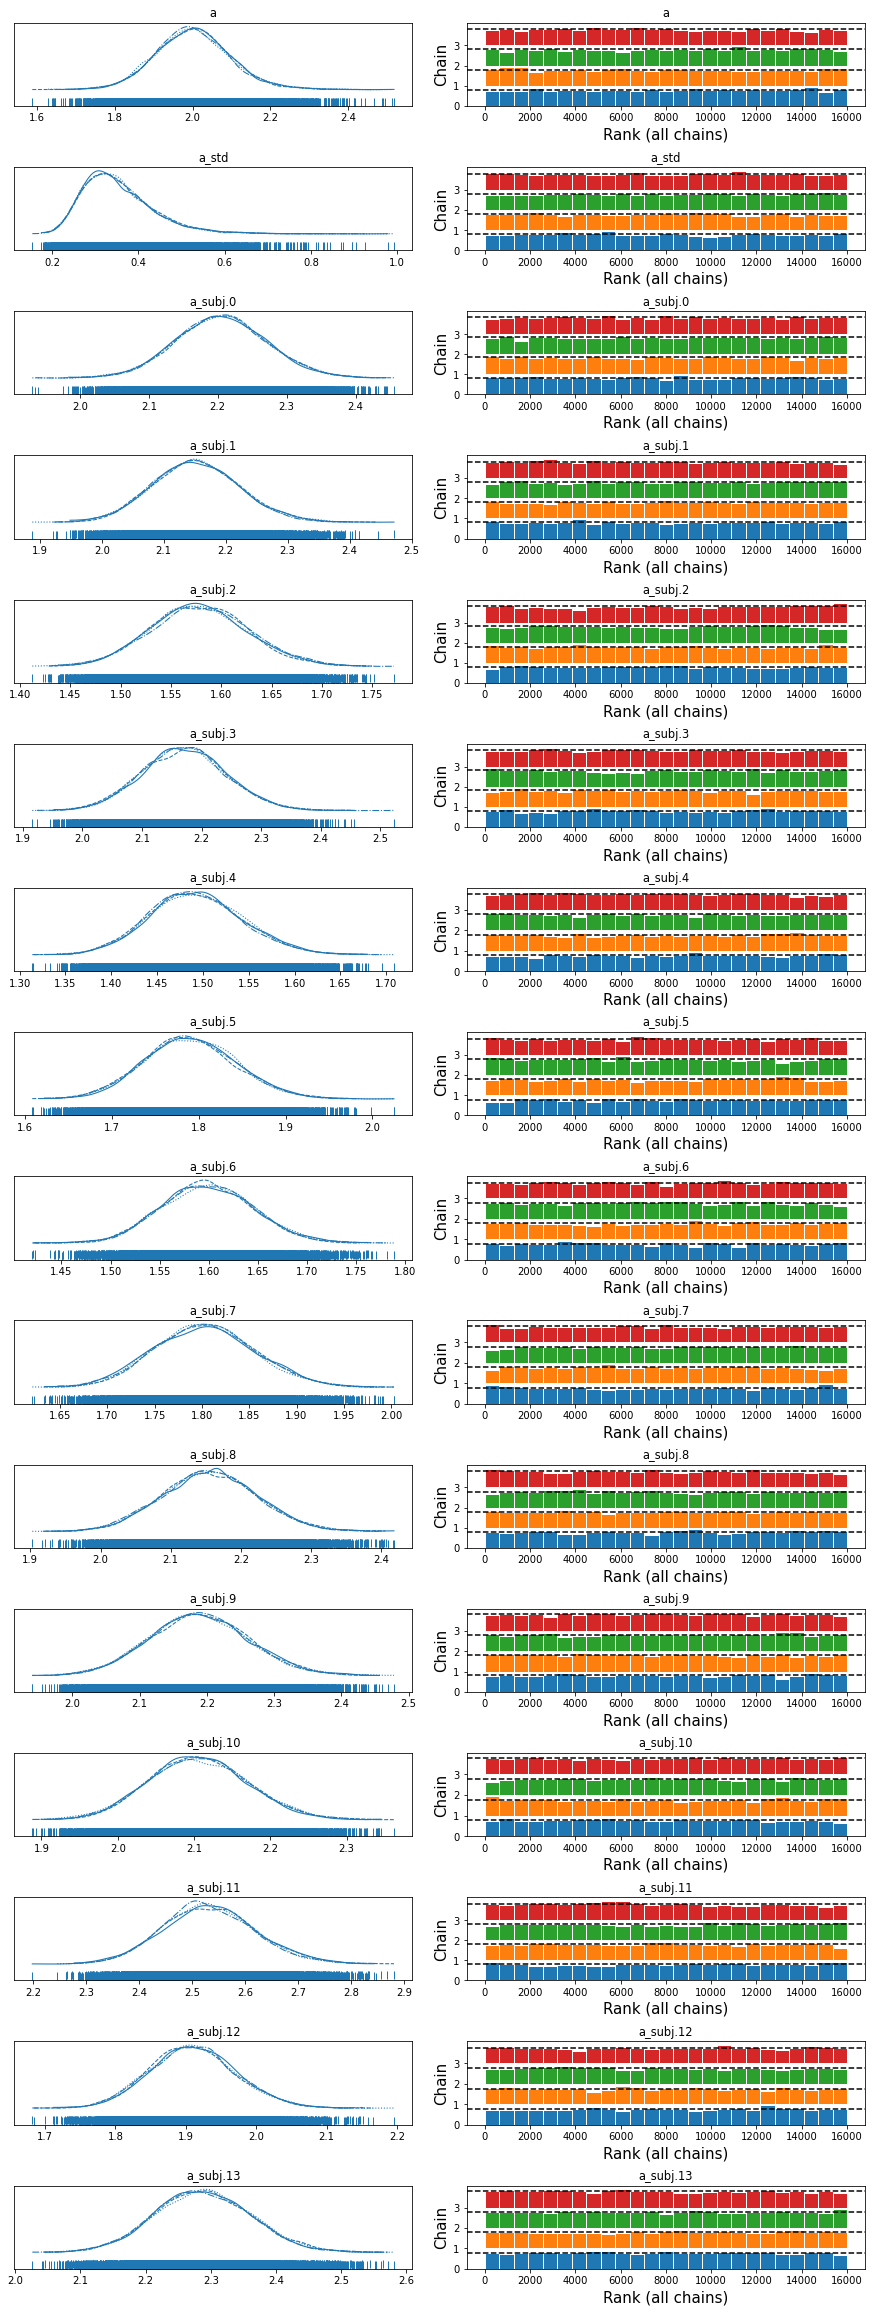

In [24]:
# plot traces
az.plot_trace(InfData_stim, var_names=("^a"), filter_vars='regex', rug=True, kind="rank_bars")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fab6e5df9d0>],
      dtype=object)

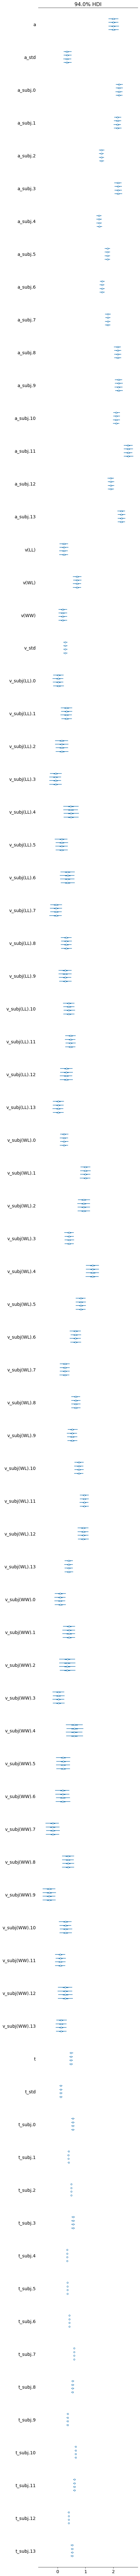

In [25]:
az.plot_forest(InfData_stim)

In [26]:
az.hdi(InfData_stim)

<xarray.Dataset>
Dimensions:        (hdi: 2)
Coordinates:
  * hdi            (hdi) <U6 'lower' 'higher'
Data variables: (12/78)
    a              (hdi) float64 1.818 2.185
    a_std          (hdi) float64 0.2165 0.505
    a_subj.0       (hdi) float64 2.086 2.335
    a_subj.1       (hdi) float64 2.024 2.286
    a_subj.2       (hdi) float64 1.49 1.672
    a_subj.3       (hdi) float64 2.04 2.305
    ...             ...
    t_subj.8       (hdi) float64 0.4951 0.5923
    t_subj.9       (hdi) float64 0.3265 0.3992
    t_subj.10      (hdi) float64 0.6184 0.6895
    t_subj.11      (hdi) float64 0.5617 0.6517
    t_subj.12      (hdi) float64 0.3743 0.4231
    t_subj.13      (hdi) float64 0.4761 0.5767

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fab6ec12b50>,
      dtype=object)

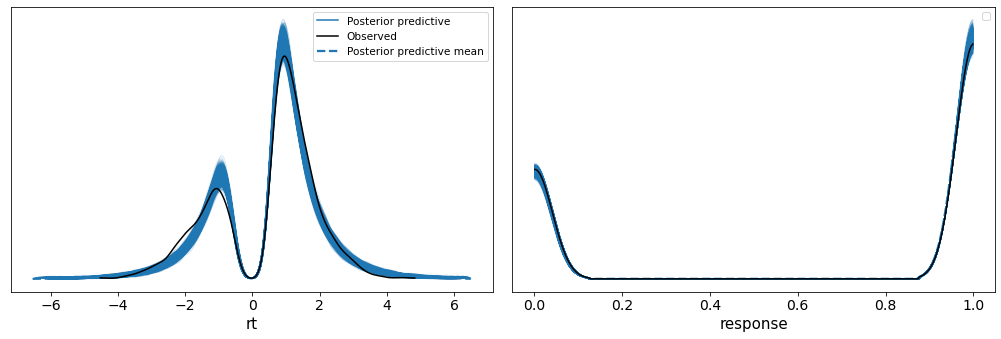

In [27]:
# plot ppc
az.plot_ppc(InfData_stim)

### Tried to draw from prior (failed)

In [28]:
tmp = m_stim_list[0]
draw_from_prior(tmp, update=False)
# tmp.draw_from_prior(update=False)

NameError: name 'draw_from_prior' is not defined

In [29]:
df_stim_priors = []
for i in range(4):
    df = m_stim_list[i]
    df_prior = df.draw_from_prior()
    df_prior['chain'] = i
    df_prior['draw'] = np.arange(len(df_prior), dtype=int)
    print('chain', i, df_prior.shape)
    df_priors.append(df_trace)
df_stim_priors = pd.concat(df_stim_priors)
df_stim_priors = df_stim_priors.set_index(["chain", "draw"])

AttributeError: Deterministic a_rate's value cannot be set.

### Tried `loo` and `waic`

In [30]:
az.loo(InfData_stim)

TypeError: log likelihood not found in inference data object

In [31]:
az.waic(InfData_stim)

TypeError: log likelihood not found in inference data object